In [1]:
import os
import pandas as pd
import numpy as np
import pyedflib
import neurokit2 as nk
import matplotlib.pyplot as plt
import math
import seaborn as sns

import hrvanalysis as hrvana

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

e:\virual_env\CS909\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
overlap_Rpoint = "E:/mesa/polysomnography/annotations-rpoints/"
edfs_path = "E:/mesa/polysomnography/edfs/"
ppg_hrv_path = "E:/mesa/features/ppg_hrv/"
ppg_hrv_stand_path = "E:/mesa/features/ppg_hrv_stand/"
sample_id_file = "E:/mesa/expriment_samples.txt"

In [3]:
with open(sample_id_file, 'r') as file:
    lines = file.readlines()

expriment_id_list = [line.strip() for line in lines]
# 输出列表内容
print(expriment_id_list)

['5119', '3974', '1113', '3737', '0468', '1381', '2325', '1431', '0893', '6727', '5162', '0392', '0683', '3293', '5830', '1098', '5369', '1459', '1022', '0144', '1077', '6450', '3793', '6266', '1797', '6052', '2567', '3554', '4527', '2549', '6370', '5740', '5001', '1752', '0904', '3710', '2100', '5031', '3042', '2030', '0914', '5195', '3664', '6337', '0036', '6067', '4880', '5268', '4958', '3703', '1546', '4974', '0074', '1641', '2429', '4309', '4555', '4345', '6557', '4795', '6789', '5127', '5990', '5635', '2212', '5955', '1959', '0427', '5673', '0789', '0110', '6784', '0791', '6616', '2796', '5390', '5932', '4333', '1020', '5503', '1087', '4683', '2451', '5669', '2170', '0910', '3251', '0458', '0594', '0528', '2709', '6722', '0862', '5513', '3332', '4529', '2035', '2217', '2488', '0332']


In [4]:
all_Rpoint = os.listdir(overlap_Rpoint)
all_edfs = os.listdir(edfs_path)

In [5]:
def map_to_epoch(value):
    interval = int(math.ceil(value / 30))  # 使用ceil函数向上取整
    return interval

In [6]:
def epoch_map_stage(Rpoint_df,PPG_df):
    mapping_dict = {}

    # 遍历DataFrame的每一行
    for index, row in Rpoint_df.iterrows():
        epoch_value = row['epoch']
        stage_value = row['stage']
        
        # 如果attr1_value不在字典中，则添加到字典，并将attr2_value作为值
        if epoch_value not in mapping_dict:
            mapping_dict[int(epoch_value)] = int(stage_value)
    PPG_df['stage'] = PPG_df['epoch'].map(mapping_dict)

In [64]:
def standardize_df_given_feature(df, features=[], scaler=None, df_name="", simple_method=True):
    assert len(features) > 0, print("feature length must greater than 0")
    # check if the df contains nan or inf
    if simple_method:
        print("pre-processing dataset frame using simple method")
        df[features] = df[features].replace([np.inf, -np.inf], np.nan)
        df[features] = df[features].fillna(df[features].mean())
        # df[~np.isfinite(df)] = np.nan
        nan = df[df.isnull().any(axis=1)]
        if nan.shape[0] > 0:
            print("df contains nan")
        inf = df[df.eq(np.inf).any(axis=1)]
        if inf.shape[0] > 0:
            print("df contains inf")
    else:
        print("pre-processing dataset frame using comprehensive method")
        for feature in features:
            print("quality check on %s for column name: % s" % (df_name, feature))
            if df[feature].isnull().values.any():
                df[feature] = df[feature].replace(np.nan, df[~df[feature].isin([np.nan, np.inf, -np.inf])][feature].mean())
            if df[feature].isin([np.inf]).values.any():
                df[feature] = df[feature].replace(np.inf, df[~df[feature].isin([np.nan, np.inf, -np.inf])][feature].max())
            if df[feature].isin([-np.inf]).values.any():
                df[feature] = df[feature].replace(-np.inf, df[~df[feature].isin([np.nan, np.inf, -np.inf])][feature].min())

            df[feature] = df[feature].replace([np.nan, np.inf, -np.inf], 0.0)
    if scaler is None:
        scaler = StandardScaler()
        print(' Not given scaler start training scaler now!')
        scaler.fit(df[features])
    print('start transform dataset :%s' % df_name)
    df[features] = scaler.transform(df[features])
    return scaler

In [68]:
standarize = True
for PID in expriment_id_list:
    mesa_id = PID
    # filter Acc and HR based on the overlap records
    print('*' * 100)
    print("Processing subject %s dataset" % mesa_id)
    rpoint_idx = [s for s in all_Rpoint if mesa_id in s]
    ppg_idx = [s for s in all_edfs if mesa_id in s]

    #print(os.path.join(edfs_path,all_edfs[i]))
    raw_data = pyedflib.EdfReader(os.path.join(edfs_path, ppg_idx[0]))
    sample_rate = raw_data.getSampleFrequency(22)
    #print(sample_rate)
    PPG_singal = raw_data.readSignal(22)
    time = [i / sample_rate for i in range(len(PPG_singal))]
    PPG_df = pd.DataFrame({'PPG': PPG_singal, 'Time': time})
    #print(PPG_df.shape[0])
    raw_data.close()

    PPG_singals,PPG_info = nk.ppg_process(PPG_df["PPG"].values,sampling_rate=256)
    #PPG_plot = nk.ppg_plot(PPG_singals[0:6*256], sampling_rate=256, static=True)
    clean_singal = nk.ppg_clean(PPG_df["PPG"].values, sampling_rate=256, heart_rate=None, method='elgendi')
    ppg_peaks = nk.ppg_findpeaks(clean_singal,sampling_rate=256,show=False)
    ppg_peaks_df = pd.DataFrame(ppg_peaks)
    PPG_peaks_df = ppg_peaks_df.merge(PPG_df["Time"], left_on='PPG_Peaks', right_index=True)
    #print(ppg_peaks_df.shape[0])
    Rpoint_df = pd.read_csv(os.path.join(overlap_Rpoint,rpoint_idx[0]))
    Rpoint_epoch = Rpoint_df["epoch"].unique()
    #Rpoint_stages = Rpoint_df["stage"].unique()
    epoch_max = Rpoint_epoch.max()
    PPG_peaks_df['epoch'] = PPG_peaks_df['Time'].apply(map_to_epoch)
    PPG_peaks_df.head()
    PPG_peaks_df = PPG_peaks_df[PPG_peaks_df['epoch'] <= epoch_max]
    #print(PPG_peaks_df)
    epoch_map_stage(Rpoint_df,PPG_peaks_df)
    PPG_peaks_df = PPG_peaks_df.dropna(subset=["stage"])
    PPG_peaks_df['stage'] = PPG_peaks_df['stage'].astype(int)

    PPG_peaks_df["RR Intervals"] = PPG_peaks_df["Time"].diff() * 1000 # calculate the value difference between two adjacent points
    #hr_df['RR Intervals'].fillna(hr_df['RR Intervals'].mean(), inplace=True)
    PPG_peaks_df['RR Intervals'].fillna(PPG_peaks_df['RR Intervals'].mean(), inplace=True)
    #PPG_peaks_df = PPG_peaks_df.fillna(PPG_peaks_df['RR Intervals'].mean())
    #print(PPG_peaks_df.isnull().values.any())
    clean_rri = PPG_peaks_df['RR Intervals'].values

    clean_rri = hrvana.remove_outliers(rr_intervals=clean_rri, low_rri=300, high_rri=2000)
    clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")
    clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
    clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri)

    t1 = PPG_peaks_df.epoch.value_counts().reset_index().rename({'index': 'epoch_idx', 'epoch': 'count'}, axis=1)
    invalid_idx = set(t1[t1['count'] < 3]['epoch_idx'].values)
    del t1

    PPG_peaks_df = PPG_peaks_df[~PPG_peaks_df['epoch'].isin(list(invalid_idx))]

    feature_list = []
    hrv_win = 0
        # go through all sleep epochs and extract HRV features from them
    for index, hr_epoch_idx in enumerate(PPG_peaks_df['epoch'].unique()):
        gt_label = PPG_peaks_df[PPG_peaks_df['epoch'] == hr_epoch_idx]["stage"].values[0]  # in MESA r-points files, the stage is annotated by the sleep experts
        if hrv_win != 0:  # if you want get the features from a 5 min window, please set hrv_win = 10, as per sleep epoch is 30s
            offset = int(np.floor(hrv_win/2))
            tmp_hr_df = PPG_peaks_df[PPG_peaks_df['epoch'].isin(np.arange(hr_epoch_idx-offset, hr_epoch_idx+offset))]
        else:
            tmp_hr_df = PPG_peaks_df[PPG_peaks_df['epoch'] == hr_epoch_idx]
        try:  # check to see if the first time stamp is empty
            start_sec = float(tmp_hr_df['Time'].head(1) * 1.0)
        except Exception as ee:
            print("Exception %s, source dataset: %s" % (ee, tmp_hr_df['Time'].head(1)))
        # calculate the HRV features for each epoch
        rr_epoch = tmp_hr_df['RR Intervals'].values
        all_hr_features = {}
        try:
            all_hr_features.update(hrvana.get_time_domain_features(rr_epoch))
        except Exception as ee:
            print("processed time domain features with error message: {}".format(str(ee)))
        try:
            all_hr_features.update(hrvana.get_frequency_domain_features(rr_epoch))
        except Exception as ee:
            print("processed frequency domain features with error message: {}".format(str(ee)))
        try:
            all_hr_features.update(hrvana.get_poincare_plot_features(rr_epoch))
        except Exception as ee:
            print("processed poincare features: {} with error message".format(str(ee)))
        try:
            all_hr_features.update(hrvana.get_csi_cvi_features(rr_epoch))
        except Exception as ee:        
            print("processed csi cvi domain features: {} with error message".format(str(ee)))
        try:
            all_hr_features.update(hrvana.get_geometrical_features(rr_epoch))
        except Exception as ee:
            print("processed geometrical features: {} with error message".format(str(ee)))

        all_hr_features.update({'stages': gt_label
                                #, 'mesaid': str(mesa_id)                            
                                , 'epoch': hr_epoch_idx
                                #, 'index': index
                                })
        feature_list.append(all_hr_features)
    hrv_feature_df = pd.DataFrame(feature_list)
    del hrv_feature_df['tinn']
    hrv_feature_df.loc[hrv_feature_df['stages'] > 4, 'stages'] = 4  # make sure rem sleep label is 4
    hrv_feature_df = hrv_feature_df.fillna(hrv_feature_df.median())
    print(hrv_feature_df.isnull().values.any())
    
    feature_list = hrv_feature_df.columns.to_list()
    std_feature = [x for x in feature_list if x not in ['two_stages', 'seconds', 'interval',
                                                                'wake', 'linetime', 'mesaid', 'stages', 'line',"epoch"]]
    if standarize:
        standardize_df_given_feature(hrv_feature_df, std_feature, df_name='hrv_feature_df', simple_method=False)
    hrv_feature_df.to_csv(os.path.join(ppg_hrv_stand_path, (mesa_id + '_ppg_hrv_stand_features.csv')), index=False)



****************************************************************************************************
Processing subject 5119 dataset
345 outlier(s) have been deleted.
The outlier(s) value(s) are : [2480.46875, 3535.15625, 3437.5, 2550.78125, 2500.0, 2703.125, 2175.78125, 4195.3125, 4214.84375, 5078.125, 5878.90625, 2660.15625, 2566.40625, 2546.875, 2535.15625, 3335.9375, 2609.375, 7746.09375, 2523.4375, 3355.46875, 3371.09375, 2503.90625, 2636.71875, 5058.59375, 4242.1875, 14679.6875, 5171.875, 2585.9375, 2636.71875, 2503.90625, 2488.28125, 12785.15625, 3105.46875, 3363.28125, 2406.25, 2601.5625, 2519.53125, 3402.34375, 2398.4375, 6648.4375, 3335.9375, 3347.65625, 3339.84375, 2484.375, 2433.59375, 2500.0, 2519.53125, 3242.1875, 3308.59375, 3328.125, 2253.90625, 2484.375, 2550.78125, 2605.46875, 2363.28125, 3375.0, 2523.4375, 2433.59375, 2542.96875, 2933.59375, 6050.78125, 2230.46875, 2386.71875, 5042.96875, 3316.40625, 3285.15625, 2480.46875, 2562.5, 2105.46875, 3359.375, 2121.09375, 2

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 110, using nperseg = 110
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 109, using nperseg = 109
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 84, using nperseg = 84
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 109, using nperseg = 109
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 110, using nperseg = 110
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 16, using nperseg = 16
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 79, using nperseg = 79
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\hrvanalysis\extract_features.py:187: RuntimeWarning: divide by zero encountered in longlong_scalars
  triang_idx = len(nn_intervals) / max(np.histogram(nn_intervals, bins=range(300, 2000, 8))[0])
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 110, using nperseg = 110
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 110, using nperseg = 110
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 85, using nperseg = 85
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 86, using nperseg = 86
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 53, using nperseg = 53
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 92, using nperseg = 92
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 36, using nperseg = 36
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: User

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 110, using nperseg = 110
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 109, using nperseg = 109
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 18, using nperseg = 18
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 87, using nperseg = 87
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 83, using nperseg = 83
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 104, using nperseg = 104
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 95, using nperseg = 95
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 77, using nperseg = 77
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: 

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 23, using nperseg = 23
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 49, using nperseg = 49
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: 

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 111, using nperseg = 111
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 94, using nperseg = 94
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 101, using nperseg = 101
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 107, using nperseg = 107
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 120, using nperseg = 120
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 113, using nperseg = 113
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 112, using nperseg = 112
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 114, using nperseg = 114
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 118, using nperseg = 118
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 115, using nperseg = 115
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 117, using nperseg = 117
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 119, using nperseg = 119
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 108, using nperseg = 108
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 116, using nperseg = 116
  .format(nperseg, input_length))
e:\virual_env\CS909\lib\site-packages\scipy\signal\spectral.py:19

False
pre-processing dataset frame using comprehensive method
quality check on hrv_feature_df for column name: mean_nni
quality check on hrv_feature_df for column name: sdnn
quality check on hrv_feature_df for column name: sdsd
quality check on hrv_feature_df for column name: nni_50
quality check on hrv_feature_df for column name: pnni_50
quality check on hrv_feature_df for column name: nni_20
quality check on hrv_feature_df for column name: pnni_20
quality check on hrv_feature_df for column name: rmssd
quality check on hrv_feature_df for column name: median_nni
quality check on hrv_feature_df for column name: range_nni
quality check on hrv_feature_df for column name: cvsd
quality check on hrv_feature_df for column name: cvnni
quality check on hrv_feature_df for column name: mean_hr
quality check on hrv_feature_df for column name: max_hr
quality check on hrv_feature_df for column name: min_hr
quality check on hrv_feature_df for column name: std_hr
quality check on hrv_feature_df for co

In [7]:
def draw_cof_martix(y_PSG_stages_label,y_PSG_stages_pred):   

    conf_martix = confusion_matrix(y_PSG_stages_label,y_PSG_stages_pred)

    # 打印混淆矩阵
    print("hrv feature 3 classification Confusion Matrix:")
    print(conf_martix)

    # 计算每个类别的总数
    class_totals = np.sum(conf_martix, axis=1)
    class_names = np.unique(y_PSG_stages_label)

    # 计算每个单元格的百分比
    cell_percentages = conf_martix / class_totals[:, np.newaxis]
    cell_numbers = conf_martix

    # 绘制混淆矩阵热图
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cell_percentages,annot=False, cmap='Blues', fmt='.2%', xticklabels= class_names, yticklabels= class_names)
    

    for i in range(len( class_names)):
        for j in range(len(class_names)):
            ax.text(j + 0.5, i + 0.5, f'{cell_percentages[i, j]:.2%}\n{cell_numbers[i, j]}',
                ha='center', va='center', color='black')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

In [22]:
all_ppg_hrv = os.listdir(ppg_hrv_path)
df_list = []
for item in all_ppg_hrv:
    ppg_hrv_df = pd.read_csv(os.path.join(ppg_hrv_path,item))
    df_list.append(ppg_hrv_df)
all_ppg_hrv_df = pd.concat(df_list)
print(all_ppg_hrv_df.shape[0])

111451


In [24]:
hrv_feature_names = ["mean_nni","sdnn","sdsd","nni_50","pnni_50","nni_20","pnni_20","rmssd","median_nni","range_nni","cvsd","cvnni","mean_hr",
                     "max_hr","min_hr", "std_hr","lf","hf","lf_hf_ratio","lfnu","hfnu","total_power","vlf","sd1", "sd2","ratio_sd2_sd1","csi",
                     "cvi","Modified_csi", "triangular_index"]

In [25]:
PSG_Labels = all_ppg_hrv_df["stages"]
ppg_hrv_features = all_ppg_hrv_df[hrv_feature_names]
print(ppg_hrv_features.shape[1])

30


In [26]:
print(ppg_hrv_features.isnull().any().any())
print(np.any(np.isinf(ppg_hrv_features.values)))

False
True


In [27]:
ppg_hrv_features.replace([np.inf, -np.inf], np.nan, inplace=True)
print(ppg_hrv_features.shape[0])
# 使用中位数填充 NaN 值

ppg_hrv_features = ppg_hrv_features.fillna(ppg_hrv_features.median())

print(np.any(np.isinf(ppg_hrv_features.values)))

111451
False


e:\virual_env\CS909\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


# Machine Learning

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}, Best Score: 0.6814602960969044 
Accuracy: 0.6837288591808354, F1 Score: 0.4976649218759525 
hrv feature 3 classification Confusion Matrix:
[[ 4472  3152    68]
 [ 1356 10646    92]
 [  489  1893   123]]


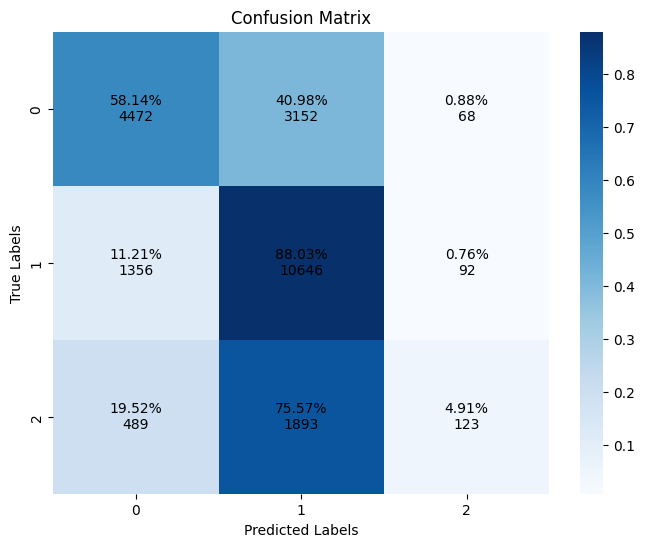

In [32]:
feature_train, feature_test, labels_train, lables_test = train_test_split(ppg_hrv_features, class_3_labels, test_size=0.2, random_state=42)
RF_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto']
}

rf = RandomForestClassifier(n_jobs=5, max_features='sqrt', n_estimators=300, oob_score=True)

grid_search = GridSearchCV(estimator=rf, param_grid=RF_param_grid,n_jobs=4, cv=5, scoring="accuracy", verbose=1, pre_dispatch=10)
grid_search.fit(feature_train, labels_train)
print("Best Parameters: %s, Best Score: %s "%(grid_search.best_params_,grid_search.best_score_))

best_model = grid_search.best_estimator_
best_model.fit(feature_train, labels_train)
pred_labels = best_model.predict(feature_test)

Accuracy = accuracy_score(lables_test , pred_labels)
F1_score = f1_score(lables_test , pred_labels, average='macro')
print("Accuracy: %s, F1 Score: %s "%(Accuracy,F1_score))

draw_cof_martix(lables_test , pred_labels)

# Deep learning - 8 features

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
dl_8feature_names = ["mean_nni", "sdnn", "sdsd", "vlf", "lf", "hf", "lf_hf_ratio", "total_power"]

In [11]:
def build_window_feature(df,win_len=20,feature_list=[]):
    fill_values = {}
    df_x = df[feature_list].copy()
    for s in range(1,round(win_len/2)+1):
        for feature in feature_list:
            df_x["%s_shift_%d" %(feature,s)] = df_x[feature].shift(s)
            # columns = df_x.columns.tolist()
            # columns = columns[::-1]  # or data_frame = data_frame.sort_index(ascending=True, axis=0)
            # df_x = df_x[columns]
            fill_values["%s_shift_%d" %(feature,s)] = df_x.loc[s:s+round(win_len/2)+1, feature].mean()


    #test_df.fillna(fill_value)
    for s in range(1,round(win_len/2)+1):
        for feature in feature_list:
            df_x["%s_shift_-%d" %(feature,s)] = df_x[feature].shift(-s)
            fill_values["%s_shift_-%d" %(feature,s)] = df_x.iloc[-(s+round(win_len/2)+1):-s][feature].mean()
            #print(df.loc[-(s+round(win_len/2)+1), feature])

    for column, value in fill_values.items():
        df_x[column].fillna(value, inplace=True)
    #print(fill_values)
    df_x.sort_index()
    return df_x

In [12]:
def pre_features_labels(path,win_length,feature_names):
#     all_ppg_hrv = os.listdir(ppg_hrv_path)
# df_list = []
# for item in all_ppg_hrv:
#     ppg_hrv_df = pd.read_csv(os.path.join(ppg_hrv_path,item))
#     df_list.append(ppg_hrv_df)
# all_ppg_hrv_df = pd.concat(df_list)
# print(all_ppg_hrv_df.shape[0])
    all_ppg_df_list = os.listdir(path)
    all_hrv_list = []
    label_list =[]
    for data_file in all_ppg_df_list:

        all_feature_df = pd.read_csv(os.path.join(path,(path + data_file)))
        all_feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        all_feature_df = all_feature_df.fillna(all_feature_df.median())

        label = all_feature_df["stages"].to_list()
        label_list = label_list+label

        #hrv_feature_df = all_feature_df[dl_hrv_feature_names]
        
        hrv_feature_df=build_window_feature(all_feature_df,win_length,feature_names)
        #print(type(hrv_feature_df))
        #print(hrv_feature_20_df.shape[1])
        all_hrv_list.append(hrv_feature_df)
        
    process_df = pd.concat(all_hrv_list)
    # process_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    #print(process_df.shape[0])
# 使用中位数填充 NaN 值

    # process_df = process_df.fillna(process_df.median())
    return process_df,label_list

In [13]:
def reshape_feature(df,feature_nums,sequnence_len):
    samples_nums = df.shape[0]
    data_array = df.values

    # 初始化一个用于存储新形状的数组
    feature_array = np.zeros((samples_nums, feature_nums, sequnence_len))

# 将每个样本重新形状并存储到新数组中
    for i in range(samples_nums):
        sample = data_array[i]  # 获取一个样本的数据
        reshaped_sample = sample.reshape(feature_nums, sequnence_len)  # 重新形状为 8x101
        feature_array[i] = reshaped_sample
    return feature_array

In [14]:
def pre_data_loader(feature,label,batch_size,Reshape = False,feature_nums=8,Seq_len=21):
    label_np = np.expand_dims(label, -1).astype(np.float32)
    #print(label_np)
    enc = OneHotEncoder(handle_unknown='ignore')#如果 handle_unknown='ignore'，则在进行编码时，如果遇到未知的分类变量取值，会忽略该取值并将对应的编码向量全部置为 0。
    labels = enc.fit_transform(label_np).toarray()
    print(labels)

    if Reshape:
        feature_reshaped = reshape_feature(feature,feature_nums,Seq_len)
        features_tensor= torch.tensor(feature_reshaped, dtype=torch.float32)
    else:
        features_tensor= torch.tensor(feature.values, dtype=torch.float32)
        features_tensor = features_tensor.unsqueeze(1)

    label_tensor = torch.tensor(labels, dtype=torch.long)
    
    dataset = TensorDataset(features_tensor, label_tensor)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader


In [15]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [16]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [17]:
def eval_model(model,moel_path,test_data):   
    model.load_state_dict(torch.load(moel_path))
    model.to('cpu')
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_data:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    #print(all_predictions,all_targets)

    # all_predictions = np.argmax(np.array(all_predictions), axis=1)
    all_targets = np.argmax(np.array(all_targets), axis=1)
            
    accuracy = accuracy_score(all_targets, all_predictions)
    print('Accuracy: {:.2%}'.format(accuracy))
    precision = precision_score(all_targets, all_predictions, average='macro')
    print(f'Precision:: {precision:.4f}')
    recall = recall_score(all_targets, all_predictions, average='macro')
    print(f'Recall: {recall:.4f}')
    f1 = f1_score(all_targets, all_predictions, average='macro')  # 你可以选择 'micro'、'macro' 或其他适合的值
    print(f'F1 Score: {f1:.4f}')
    draw_cof_martix(all_targets,all_predictions)

In [18]:
def train_save(num_epochs,model,model_path,criterion, optimizer,train_data,val_data):   
    #num_epochs = 20
    best_loss = float("inf")
    #CNN_100_model_path = './models/DL_CNN_100_best_model.pth'
    patience = 5  # 连续多少个周期验证集损失不下降就停止
    counter = 0
    for epoch in range(num_epochs):
        train_loss = train(model, train_data, criterion, optimizer)
        val_loss = validate(model,val_data, criterion)
        if val_loss<best_loss:
            #torch.save(CNN_model.state_dict(), CNN_100_model_path)
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            torch.save(model.state_dict(), model_path)
            print("Early stopping triggered. Training stopped.")
            break
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

In [19]:
ppg_8feature_100_df, PSG_label_list = pre_features_labels(ppg_hrv_stand_path,100,dl_8feature_names)
print(ppg_8feature_100_df.shape[0],ppg_8feature_100_df.shape[1])
ppg_8feature_100_df.tail()

e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
e:\virual_env\CS909\lib\site-packages\ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, 

111451 808


,mean_nni,sdnn,sdsd,vlf,lf,hf,lf_hf_ratio,total_power,mean_nni_shift_1,sdnn_shift_1,...,lf_hf_ratio_shift_-49,total_power_shift_-49,mean_nni_shift_-50,sdnn_shift_-50,sdsd_shift_-50,vlf_shift_-50,lf_shift_-50,hf_shift_-50,lf_hf_ratio_shift_-50,total_power_shift_-50
1024,0.013453,0.124883,0.129657,-0.029878,-0.031278,-0.029971,-0.170818,-0.030677,0.457488,0.186595,...,0.094503,-0.03157,-0.041526,-0.042694,-0.048535,-0.03179,-0.031578,-0.031389,0.076897,-0.031572
1025,0.229507,0.136897,0.141719,-0.030981,-0.028691,-0.025394,0.395818,-0.028308,0.013453,0.124883,...,0.094503,-0.03157,-0.041526,-0.042694,-0.048535,-0.03179,-0.031578,-0.031389,0.076897,-0.031572
1026,4.663823,2.477972,2.957067,0.236450,0.135098,0.017207,6.823462,0.125202,0.229507,0.136897,...,0.094503,-0.03157,-0.041526,-0.042694,-0.048535,-0.03179,-0.031578,-0.031389,0.076897,-0.031572
1027,2.668482,1.606645,1.981440,0.018044,0.011123,0.010832,1.557205,0.012397,4.663823,2.477972,...,0.094503,-0.03157,-0.041526,-0.042694,-0.048535,-0.03179,-0.031578,-0.031389,0.076897,-0.031572
1028,31.586455,31.907581,31.833396,32.060792,32.061814,32.062347,1.537409,32.061872,2.668482,1.606645,...,0.094503,-0.03157,-0.041526,-0.042694,-0.048535,-0.03179,-0.031578,-0.031389,0.076897,-0.031572


In [20]:
class_2_labels = []#0=weak,1=sleep
class_3_labels = []#0=weak,1/2/3=NREM=1,4=REM=2
class_4_lables = []#0=weak,1/2=light sleep=1, 3=deep sleep=2,4=REM=3
for labels in PSG_label_list:
    if labels == 0:
        class_2_labels.append(0)
        class_3_labels.append(0)
        class_4_lables.append(0)
    elif labels == 1:
        class_2_labels.append(1)
        class_3_labels.append(1)
        class_4_lables.append(1)
    elif labels == 2:
        class_2_labels.append(1)
        class_3_labels.append(1)
        class_4_lables.append(1)
    elif labels == 3:
        class_2_labels.append(1)
        class_3_labels.append(1)
        class_4_lables.append(2)
    elif labels == 4:
        class_2_labels.append(1)
        class_3_labels.append(2)
        class_4_lables.append(3)
print(set(class_2_labels))
print(set(class_3_labels))
print(set(class_4_lables))

{0, 1}
{0, 1, 2}
{0, 1, 2, 3}


In [21]:
hrv_100_X_train_val, hrv_100_X_test, hrv_100_Y_train_val, hrv_100_Y_test = train_test_split(ppg_8feature_100_df, class_3_labels, test_size=0.2, random_state=42)
hrv_100_X_train, hrv_100_X_val,hrv_100_Y_train,hrv_100_Y_val = train_test_split(hrv_100_X_train_val, hrv_100_Y_train_val, test_size=0.2, random_state=42)

In [22]:
hrv_100_train_dataloader = pre_data_loader(hrv_100_X_train, hrv_100_Y_train,64)
hrv_100_val_dataloader = pre_data_loader(hrv_100_X_val,hrv_100_Y_val,64)
hrv_100_test_dataloader = pre_data_loader(hrv_100_X_test,hrv_100_Y_test,64)
print(hrv_100_train_dataloader,hrv_100_val_dataloader,hrv_100_test_dataloader)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
<torch.utils.data.dataloader.DataLoader object at 0x000001AE2C693108> <torch.utils.data.dataloader.DataLoader object at 0x000001AE36936FC8> <torch.utils.data.dataloader.DataLoader object at 0x000001AE36924908>


## CNN model

In [23]:
class CNN_8feature(nn.Module):
    def __init__(self):
        super(CNN_8feature, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=7)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        self.fc1 = nn.Linear(50944, 256)
        self.fc2 =  nn.Linear(256, 3) # 全连接层的输入大小为 16 * 162

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool1d(x, kernel_size=2)  # 最大池化
        x = x.view(x.size(0), -1)  # 展平特征向量，以便全连接层处理
        #print(x.shape)
        x = self.fc1(x)
        x= torch.relu(x)
        x = self.fc2(x)
        return x

In [24]:
CNN_model_8feature = CNN_8feature().to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(CNN_model_8feature.parameters(), lr=0.0001, alpha=0.9)

Epoch [1/40] - Train Loss: 0.4471, Val Loss: 0.4237
Epoch [2/40] - Train Loss: 0.3956, Val Loss: 0.3969
Epoch [3/40] - Train Loss: 0.3635, Val Loss: 0.3810
Epoch [4/40] - Train Loss: 0.3359, Val Loss: 0.3715
Epoch [5/40] - Train Loss: 0.3104, Val Loss: 0.3653
Epoch [6/40] - Train Loss: 0.2864, Val Loss: 0.3607
Epoch [7/40] - Train Loss: 0.2636, Val Loss: 0.3576
Epoch [8/40] - Train Loss: 0.2422, Val Loss: 0.3581
Epoch [9/40] - Train Loss: 0.2219, Val Loss: 0.3633
Epoch [10/40] - Train Loss: 0.2031, Val Loss: 0.3664
Epoch [11/40] - Train Loss: 0.1855, Val Loss: 0.3741
Early stopping triggered. Training stopped.
Accuracy: 79.10%
Precision:: 0.7469
Recall: 0.7010
F1 Score: 0.7190
hrv feature 3 classification Confusion Matrix:
[[ 5631  1783   278]
 [  754 10806   534]
 [  187  1122  1196]]


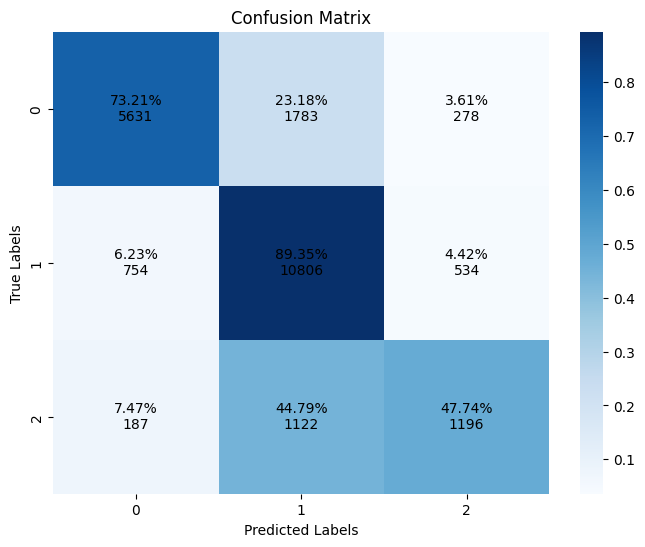

In [25]:
CNN_ppg_model_path = './ppg_models/DL_CNN_8feature_model.pth'
train_save(40,CNN_model_8feature,CNN_ppg_model_path,criterion,optimizer,hrv_100_train_dataloader,hrv_100_val_dataloader)
eval_model(CNN_model_8feature,CNN_ppg_model_path,hrv_100_test_dataloader)

## LSTM model

In [26]:
ppg_8feature_100_reshape_train_dataloader = pre_data_loader(hrv_100_X_train, hrv_100_Y_train,64,Reshape=True,feature_nums=8,Seq_len=101)
ppg_8feature_100_reshape_val_dataloader = pre_data_loader(hrv_100_X_val,hrv_100_Y_val,64,Reshape=True,feature_nums=8,Seq_len=101)
ppg_8feature_100_reshape_test_dataloader = pre_data_loader(hrv_100_X_test,hrv_100_Y_test,64,Reshape=True,feature_nums=8,Seq_len=101)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [27]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        
        # LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # 全连接层用于分类
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # LSTM 前向传播
        out, _ = self.lstm(x)
        
        # 取最后一个时间步的输出，作为全连接层的输入
        out = out[:, -1, :]
        
        # 使用全连接层进行分类
        out = self.fc(out)
        return out

In [28]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM 隐藏单元数量
num_layers = 2 # LSTM 层数
num_classes = 3  # 分类类别数量

# 创建 LSTM 模型
LSTM_8feature_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_8feature_model.parameters(), lr=0.0001, alpha=0.9)
# 打印模型结构
print(LSTM_8feature_model)

LSTMClassifier(
  (lstm): LSTM(101, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


Epoch [1/40] - Train Loss: 0.4898, Val Loss: 0.4784
Epoch [2/40] - Train Loss: 0.4613, Val Loss: 0.4643
Epoch [3/40] - Train Loss: 0.4473, Val Loss: 0.4561
Epoch [4/40] - Train Loss: 0.4366, Val Loss: 0.4460
Epoch [5/40] - Train Loss: 0.4263, Val Loss: 0.4394
Epoch [6/40] - Train Loss: 0.4151, Val Loss: 0.4327
Epoch [7/40] - Train Loss: 0.4029, Val Loss: 0.4252
Epoch [8/40] - Train Loss: 0.3896, Val Loss: 0.4187
Epoch [9/40] - Train Loss: 0.3750, Val Loss: 0.4118
Epoch [10/40] - Train Loss: 0.3592, Val Loss: 0.4062
Epoch [11/40] - Train Loss: 0.3426, Val Loss: 0.3993
Epoch [12/40] - Train Loss: 0.3251, Val Loss: 0.3931
Epoch [13/40] - Train Loss: 0.3067, Val Loss: 0.3875
Epoch [14/40] - Train Loss: 0.2880, Val Loss: 0.3824
Epoch [15/40] - Train Loss: 0.2691, Val Loss: 0.3782
Epoch [16/40] - Train Loss: 0.2499, Val Loss: 0.3715
Epoch [17/40] - Train Loss: 0.2309, Val Loss: 0.3629
Epoch [18/40] - Train Loss: 0.2123, Val Loss: 0.3611
Epoch [19/40] - Train Loss: 0.1943, Val Loss: 0.3590
Ep

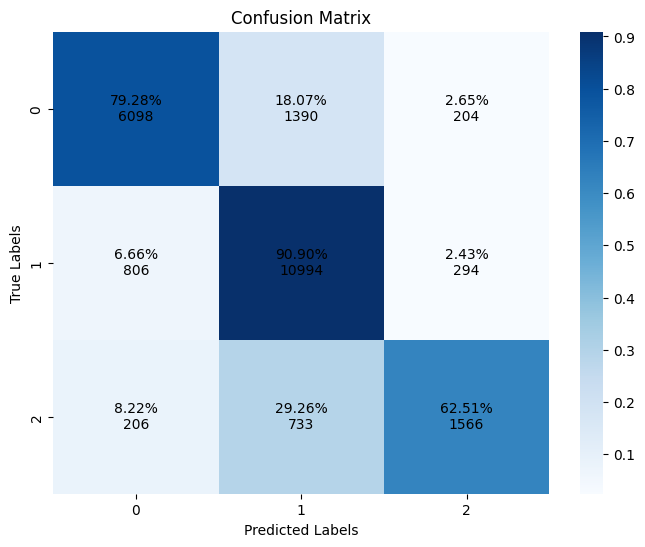

In [29]:
LSTM_8feature_model_path = './ppg_models/DL_LSTM_8feature_model.pth'
train_save(40,LSTM_8feature_model,LSTM_8feature_model_path,criterion,optimizer,ppg_8feature_100_reshape_train_dataloader,ppg_8feature_100_reshape_val_dataloader)
eval_model(LSTM_8feature_model,LSTM_8feature_model_path,ppg_8feature_100_reshape_test_dataloader)

## LSTM-Attention

In [30]:
class TransformerLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, num_heads):
        super(TransformerLSTMClassifier, self).__init__()
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # 自注意力机制（Transformer的多头注意力）
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)
        
        # 全连接层用于分类
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        # LSTM前向传播
        out, _ = self.lstm(x)
        
        # 注意力机制前向传播
        out, _ = self.attention(out.permute(1, 0, 2), out.permute(1, 0, 2), out.permute(1, 0, 2))
        out = out.permute(1, 0, 2)
        
        # 取最后一个时间步的输出，作为全连接层的输入
        out = out[:, -1, :]
        
        # 使用全连接层进行分类
        out = self.fc(out)
        return out

In [32]:
input_size = 101  # 输入特征数量
hidden_size = 1024  # LSTM隐藏单元数量
num_layers = 2  # LSTM层数
num_classes = 3  # 分类类别数量
num_heads = 8  # 自注意力机制中的注意力头数

# 创建模型
LSTM_Attention_8feature_model = TransformerLSTMClassifier(input_size, hidden_size, num_layers, num_classes, num_heads).to(device)
LSTM_Attention_8feature_model.to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.RMSprop(LSTM_Attention_8feature_model.parameters(), lr=0.0002, alpha=0.9)

Epoch [1/40] - Train Loss: 0.4884, Val Loss: 0.4772
Epoch [2/40] - Train Loss: 0.4670, Val Loss: 0.4660
Epoch [3/40] - Train Loss: 0.4527, Val Loss: 0.4503
Epoch [4/40] - Train Loss: 0.4361, Val Loss: 0.4412
Epoch [5/40] - Train Loss: 0.4174, Val Loss: 0.4299
Epoch [6/40] - Train Loss: 0.3962, Val Loss: 0.4216
Epoch [7/40] - Train Loss: 0.3720, Val Loss: 0.4092
Epoch [8/40] - Train Loss: 0.3456, Val Loss: 0.3952
Epoch [9/40] - Train Loss: 0.3165, Val Loss: 0.3893
Epoch [10/40] - Train Loss: 0.2867, Val Loss: 0.3779
Epoch [11/40] - Train Loss: 0.2574, Val Loss: 0.3557
Epoch [12/40] - Train Loss: 0.2307, Val Loss: 0.3642
Epoch [13/40] - Train Loss: 0.2061, Val Loss: 0.3473
Epoch [14/40] - Train Loss: 0.1836, Val Loss: 0.3664
Epoch [15/40] - Train Loss: 0.1660, Val Loss: 0.3575
Epoch [16/40] - Train Loss: 0.1499, Val Loss: 0.3447
Epoch [17/40] - Train Loss: 0.1349, Val Loss: 0.3417
Epoch [18/40] - Train Loss: 0.1233, Val Loss: 0.3574
Epoch [19/40] - Train Loss: 0.1138, Val Loss: 0.3527
Ep

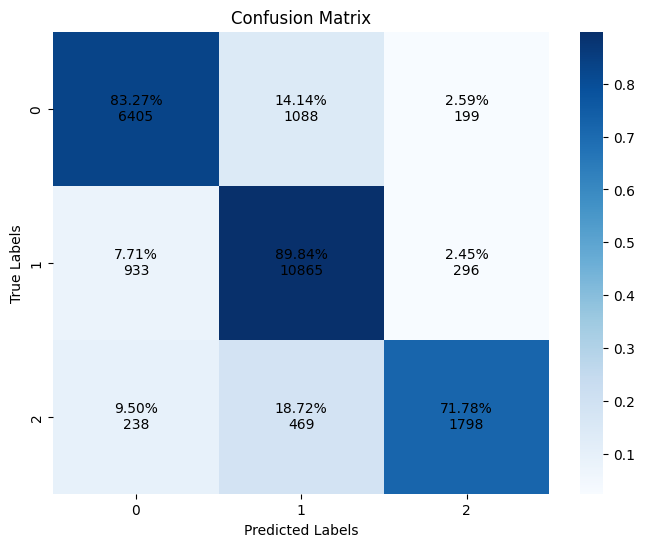

In [33]:
LSTM_Attention_8feature_model_path = './ppg_models/DL_LSTM_Attention_8feature_best_model.pth'
train_save(40,LSTM_Attention_8feature_model,LSTM_Attention_8feature_model_path,criterion,optimizer,ppg_8feature_100_reshape_train_dataloader,ppg_8feature_100_reshape_val_dataloader)
eval_model(LSTM_Attention_8feature_model,LSTM_Attention_8feature_model_path,ppg_8feature_100_reshape_test_dataloader)